# The search for NNs at its end: splitting the roles

We tried and tested the NN-xmatch workflow in past notebooks, first to build the workflow itself, [xNN_mock_sources_v1](http://nbviewer.jupyter.org/github/chbrandt/pynotes/blob/429ea32977e7a0fb24e19a5b84f9ba3716d046dc/xmatch/xNN_mock_sources_v1.ipynb), and then on developing better the algorithm and even testing the `ipyparallel` engine, [xNN_mock_sources_v2-try_parallel](http://nbviewer.jupyter.org/github/chbrandt/pynotes/blob/1fa75e0c3c9b062dbd3937fa13a1884f56a3ed48/xmatch/xNN_mock_sources_v2-try_parallel.ipynb).

Now, all we want is to the functions in proper namespaces and test so that we can add it to [booq](https://github.com/chbrandt/booq).

TOC:
* [Simulation of source images](#Simulation-of-source-images)
  * [Resultant simulation for the first image/catalog](#Result-of-the-simulation-for-the-first-image)
  * [Resultant simulation for the second image/catalog](#Result-of-the-simulation-for-the-second-image)
  * [Resultant merged images](#Merge-images)
* [Cross-match the tables](#Cross-matching)
  * [Serial](#Serial-experiment)
  * [Parallel](#Parallel-experiment)
  * [Comparison of results](#Are-they-equal?)
* [Appendix](#[-This-is-for-another-notebook:-the-functions-organized-;])

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

## Simulation of source catalogs

In [2]:
# first of all, let us define some parameters
#
# size of the images
sx = 5000
sy = 5000

# number of sources on each image
nsrc1 = int( 0.1 * (sx*sy)/(sx+sy) )

#nsrc2 = int( 0.5 * nsrc1 )

# typical error radius (in pixels)
rerr1 = 20
rerr2 = rerr1

In [3]:
class Mock:
    """
    namespace for mock catalogs generation
    """
    @staticmethod
    def generate_positions_2D(npts,img_shape):
        """
        Generates 'npts' points uniformly across 'image_shape'.

        Args:
            npts      : number of points to generate
            img_shape : (y,x) shape where to generate points

        Output:
         - list of (y,x) tuples, position of generated points
        """
        import numpy as np
        _sy,_sx = img_shape
        assert _sy>=5 and _sx>=5 # because I want
        indy = np.random.randint(0,_sy-1,npts)
        indx = np.random.randint(0,_sx-1,npts)
        _inds = zip(indy,indx)
        return _inds


    @staticmethod
    def generate_positions_2D_around(seeds,radius,img_shape,fraction=1.0):
        """
        Generates points around given seeds with a 'fraction' probability
        
        Input:
         - list of (y,x) tuples : [(int,int),...]
                 position of seed/reference points
         - radius : int
                 position is generated using a normal distribution,
                 'radius' is used as the 1-sigma value of the probability function
         - img_shape : (int,int)
                 (y,x) shape where points can be generated
         
        Output:
         - list of (y,x) tuples, position of generated points
        """
        assert 0 < fraction <= 1.0, "ValueError: 'fraction' should be somewhere between [0:1]."

        def _gen_pos_around_individual(seed,radius,img_shape,fraction,distribution='normal'):
            """
            TODO: implement other kinds of distributions
            """
            from random import random
            if random() < fraction:
                import numpy as np
                sy,sx = seed
                y = int(np.random.normal(sy,radius))
                x = int(np.random.normal(sx,radius))
                y = y if y > 0 and y < img_shape[0] else sy
                x = x if x > 0 and x < img_shape[1] else sx
            else:
                y,x = Mock.generate_positions_2D(1,img_shape)[0]
            return y,x

        _inds = []
        for i,seed in enumerate(seeds):
            y,x = _gen_pos_around_individual(seed,radius,img_shape,fraction)
            _inds.append((y,x))
        return _inds

    @staticmethod
    def generate_catalog_2D(number_sources, radius, img_shape):
        """
        """
        import pandas
        import numpy

        sy,sx = img_shape
        rerr = radius
        coords = Mock.generate_positions_2D(number_sources,(sy,sx))
        
        y,x = zip(*coords)
        df = pandas.DataFrame({ 'x':x, 'y':y, 'r':[rerr]*len(coords),
                                'ID':numpy.arange(1,len(coords)+1)})
        return df

    @staticmethod
    def generate_catalog_2D_around(reference_catalog, fraction_neighbors, img_shape):
        """
        """
        import pandas
        import numpy

        sy,sx = img_shape
        rerr = reference_catalog.r[0]
        ref_coords = reference_catalog[['y','x']].values
        fraction = fraction_neighbors
        coords = Mock.generate_positions_2D_around(ref_coords, rerr, (sy,sx), fraction)

        y,x = zip(*coords)
        df = pandas.DataFrame({ 'x':x, 'y':y, 'r':[rerr]*len(coords),
                                'ID':numpy.arange(1,len(coords)+1)})
        return df

class Coordinates:
    
    @staticmethod
    def pixel_to_sky(px, origin_in_sky, pixel_scale):
        """
        Returns the 'sky' values
        
        Pixel values are always 0 <= 'x'.
        The origin defines where 'x'=0 resides in sky (ra).
        The pixel scale is the shifting factor.
        So far, the convertion is a simple, linear function.
        
        Input:
         - px : ~numpy.ndarray
             Image (pixel) coordinates
         - origin_in_sky : float
             RA/Dec value of pixel x=0 (origin)
         - pixel_scale : float
             Pixel resolution, in 'degree/pixel'
             
        Output:
         - sky : ~numpy.ndarray
             Sky coordinates
        """
        sky = (px * float(pixel_scale)) - origin_in_sky
        return sky

    
def normalize_coordinates(A,B,norm_factor):
    """
    """
    def _normalize_coordinates(x, y, norm_fact):
        from astropy.coordinates import SkyCoord
        from astropy import units
        x_norm = x / norm_fact
        y_norm = y / norm_fact
        coord = SkyCoord(ra=x_norm, dec=y_norm, unit=units.deg)
        return coord

    A_coord = _normalize_coordinates(A.x,A.y,norm_factor)
    B_coord = _normalize_coordinates(B.x,B.y,norm_factor)
    return A_coord,B_coord


In [4]:
# # "sources 1"
# coords1 = Mock.generate_positions_2D(nsrc1,(sy,sx))
# # "sources 2"
# coords2 = Mock.generate_positions_2D_around(coords1, rerr1, (sy,sx), fraction=0.75)

# import pandas
# import numpy

# y,x = zip(*coords1)
# df1 = pandas.DataFrame({'x':x, 'y':y, 'r':[rerr1]*len(coords1), 'ID':numpy.arange(1,len(coords1)+1)})

# y,x = zip(*coords2)
# df2 = pandas.DataFrame({'x':x, 'y':y, 'r':[rerr2]*len(coords2), 'ID':numpy.arange(1,len(coords2)+1)})

df1 = Mock.generate_catalog_2D(nsrc1,rerr1,(sy,sx))
df2 = Mock.generate_catalog_2D_around(df1, 0.75, (sy,sx))


In [5]:
class Image:
    """
    namespace for all image-related functions
    """
    
    # create and draw each source on black(null) images
    @staticmethod
    def draw_image_sources(df,img_shape,colormap='colorful'):
        """
        """
        assert len(img_shape)==2
        assert 'x' in df.columns
        assert 'y' in df.columns
        assert 'r' in df.columns
        
        def color_filling(mode='colorful'):
            def _colorful(x,y,size):
                _R = int(255 - ( int(x/256) + int(y/256)*(1 + ceil(size[0]/256)) )) #TODO: restrict total size of image to avoid _R<=0
                _G = x%256
                _B = y%256
                return (_R,_G,_B)

            def _blue(x,y,size):
                _R = 0
                _G = 0
                _B = 255
                return (_R,_G,_B)

            def _green(x,y,size):
                _R = 0
                _G = 255
                _B = 0
                return (_R,_G,_B)

            def _red(x,y,size):
                _R = 255
                _G = 0
                _B = 0
                return (_R,_G,_B)

            foos = {'blue'    : _blue,
                    'red'     : _red,
                    'green'   : _green,
                    'colorful': _colorful}

            try:
                foo = foos[mode]
            except:
                foo = _colorful
            return foo


        from math import ceil
        from PIL import Image,ImageDraw
        
        size = img_shape[::-1]

        # Modification to accomplish color codes ---
        #mode = 'L'
        mode = 'RGB'
        # ---
        color = "black"
        img = Image.new(mode,size,color)
        #
        filling_foo = color_filling(colormap)
        #
        
        dictColorId = {}
        for i,src in df.iterrows():
            draw = ImageDraw.Draw(img)
            x = src.x
            y = src.y
            r = src.r
            fill = filling_foo(x,y,size)
            
            box = (x-r,y-r,x+r,y+r)
            draw.ellipse(box,fill=fill)
            
            dictColorId[str(fill)] = i
            del draw,box,x,y,r
            
        return img,dictColorId

    @staticmethod
    def pil_2_array(img):
        import numpy
        #img_array = numpy.array(list(img.getdata())).reshape(sx,sy,3)
        img_array = numpy.asarray(img)
        return img_array

    @staticmethod
    def array_2_pil(arr):
        from PIL import Image
        imgout = Image.fromarray(numpy.uint8(arr))
        return imgout

    @staticmethod
    def rgb_2_mono(img_arr,chanel='R'):
        chanels = {'R':0,
                   'G':1,
                   'B':2}
        _i = chanels[chanel]
        return img_arr[:,:,_i]



In [6]:
img1,cor2id1 = Image.draw_image_sources(df1,(sy,sx),colormap='blue')
img2,cor2id2 = Image.draw_image_sources(df2,(sy,sx),colormap='red')
# img1.show()
# img2.show()

In [7]:
# cmap reference:
#
# cm api: http://matplotlib.org/api/cm_api.html
# cmaps : http://matplotlib.org/users/colormaps.html
# imshow: http://matplotlib.org/users/image_tutorial.html
#cmap = cm.get_cmap('Blues')


### Result of the simulation for the first image

Catalog A:
----------
      ID   r     x     y
0      1  20  4028  4992
1      2  20   613  1219
2      3  20  4363  4005
3      4  20  2975  4188
4      5  20  3422  4398
5      6  20  4327  2386
6      7  20  2030  1839
7      8  20  4811  1064
8      9  20  4117  3877
9     10  20  2541  4473
10    11  20  1227   153
11    12  20  4980  1336
12    13  20  1434  4163
13    14  20   677  3891
14    15  20  3621  3925
15    16  20  2806  1549
16    17  20  1678  1692
17    18  20   918  2382
18    19  20  4207  4567
19    20  20  1187   913
20    21  20  4340  4465
21    22  20  4490  4726
22    23  20   550   111
23    24  20  2167  4818
24    25  20  1920   997
25    26  20  3121   885
26    27  20   796  2474
27    28  20   528  2417
28    29  20  3587  1844
29    30  20   753  2369
..   ...  ..   ...   ...
220  221  20  3790  1941
221  222  20  2164  3126
222  223  20  2818  3112
223  224  20  3720  2582
224  225  20  1852  1040
225  226  20  3214  1984
226  227  20  2714  4872
227

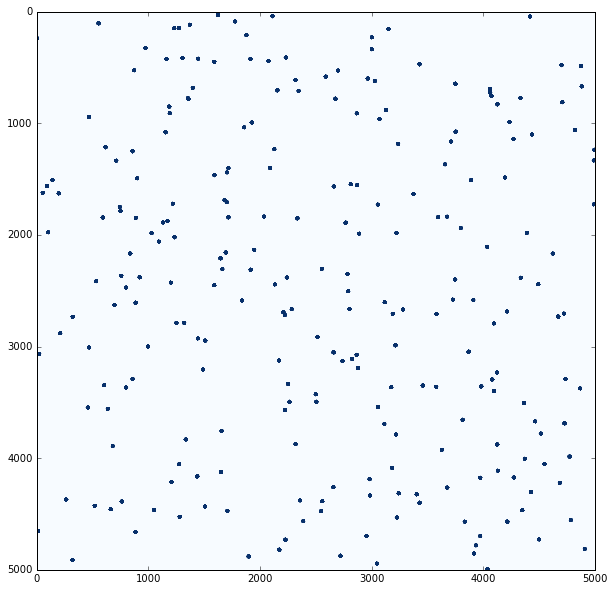

In [8]:
img1_array = Image.pil_2_array(img1)

plt.imshow( Image.rgb_2_mono(img1_array,'B'), cmap='Blues')

print "Catalog A:"
print "----------"
print df1

### Result of the simulation for the second image

Catalog B:
----------
      ID   r     x     y
0      1  20  4044  4986
1      2  20   621  1245
2      3  20  4338  3996
3      4  20  2970  4175
4      5  20  3396  4386
5      6  20  4361  2373
6      7  20  2715  4472
7      8  20  4820  1064
8      9  20  4114  3884
9     10  20  4633  2130
10    11  20  1230   156
11    12  20  4984  1364
12    13  20  1430  4146
13    14  20   716  3888
14    15  20  3617  3936
15    16  20  2802  1566
16    17  20   259  1598
17    18  20   976  4954
18    19  20  2405   437
19    20  20  1155   905
20    21  20  4338  4474
21    22  20  4500  4727
22    23  20   540   109
23    24  20  1521  4620
24    25  20  1906   986
25    26  20  3130   909
26    27  20   810  2477
27    28  20  3035  1729
28    29  20  3548  1826
29    30  20   753  2369
..   ...  ..   ...   ...
220  221  20  3803  1933
221  222  20  2161  3126
222  223  20  2458  4425
223  224  20  3722  2553
224  225  20  1825  1026
225  226  20   992  2621
226  227  20  4868  1480
227

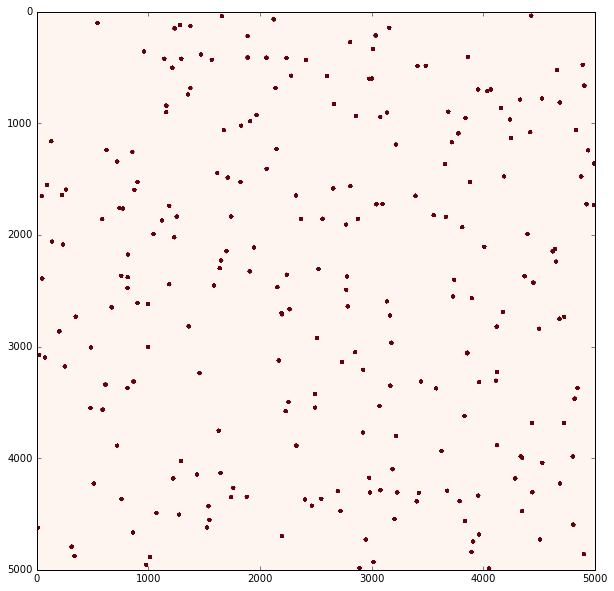

In [9]:
img2_array = Image.pil_2_array(img2)

plt.imshow( Image.rgb_2_mono(img2_array,'R'), cmap='Reds')

print "Catalog B:"
print "----------"
print df2

### Merge images

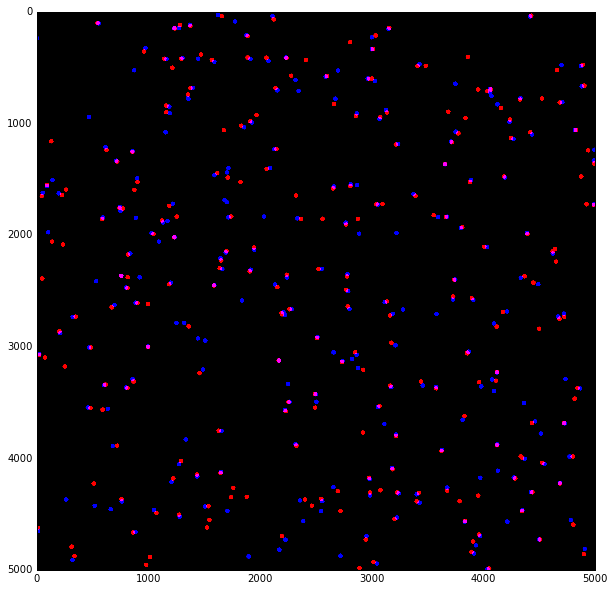

In [10]:
plt.imshow( Image.array_2_pil( img1_array+img2_array ) )

## Cross-matching

In [73]:
# ---
class IO:
    @staticmethod
    def read_catalog(filename, column_names=None, format='fits', sample_size=0):
        """
        """
        if format == 'fits':
            data = IO.read_fitsio(filename, column_names=column_names)

        if sample_size:
            data = Data.sample(data, fraction=sample_size)

        return data

    @staticmethod
    def read_fitsio(filename,column_names=None):
        """
        """
        import fitsio
        if column_names:
            catalog_data = fitsio.read(filename, columns=column_names, ext=1)
        else:
            catalog_data = fitsio.read(filename, ext=1)
        return catalog_data


# ---

class Data:
    @staticmethod
    def sample(data_array, fraction=0.1):
        """
        Returns a (normal) random sample from array' rows

        Input:
         - data_array : ~numpy.ndarray
                Array from where rows are randomly chosen
         - fraction : int, float
                Number between (0,array'length); limits are non-inclusive.
                If the number is higher (inclusive) than '1', it is assumed to be
                the absolute value for the sample size; otherwise, if between (0,1)
                it is assumed to be the relative, array-length multiplication factor.
        Output:
         - sampled_array : ~numpy.ndarray
                Rows are randomly chosen from a normal distribution, all same columns
        """
        import numpy
        nrows = len(data_array)

        assert fraction > 0, "ValueError: There is no sense in asking for 'fraction' <= 0"
        assert fraction < nrows, "ValueError: There is no sense in asking for 'fraction' >= array's length"

        nsamp = fraction if fraction >= 1 else fraction*nrows
        nsamp = int(nsamp)
        idx = numpy.random.randint(0, nrows, nsamp)
        sample_data = data_array[idx]

        return sample_data

# ---

class Xmatch:

    @staticmethod
    def xmatch_nn(A_coord, B_coord, parallel=False):
        """
        """
        if parallel:
            match_A_nn_idx, match_A_nn_sep = Xmatch.xmatch_nn_parallel(A_coord,B_coord)
        else:
            match_A_nn_idx, match_A_nn_sep = Xmatch.xmatch_nn_serial(A_coord,B_coord)
        return (match_A_nn_idx, match_A_nn_sep)

    @staticmethod
    def xmatch_nn_serial(pin, neiborhood):
        """
        Nearest-Neighbor search

        Input:
         - pin : ~astropy.coordinates.SkyCoord
                reference catalog (catalog "A")
         - neiborhood : ~astropy.coordinates.SkyCoord
                matching catalog (catalog "B")

        Output:
         - tuple with ~numpy.ndarray , ~astropy.units.Quantity
                array of respective (to 'pin') index entries in 'neiborhood'
                , array of respective pair distances
        """
        A_coord = pin
        B_coord = neiborhood

        from astropy.coordinates import SkyCoord
        assert isinstance(A_coord,SkyCoord)
        assert isinstance(B_coord,SkyCoord)

        from astropy.coordinates import match_coordinates_sky
        match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord,B_coord)

        assert len(match_A_nn_idx) == len(A_coord)
        assert match_A_nn_idx.max() < len(B_coord)

        return (match_A_nn_idx, match_A_nn_sep.value)


    @staticmethod
    def xmatch_nn_parallel(A_coord,B_coord,nprocs=2):
        """
        """

        def parallel_setup(nprocs=2):
            """
            Run xmatch in parallel

            It splits the first array in 'nprocs' for parallel processing,
            then it concatenates the outputs and return that.
            """
            #TODO: do all the verifications for parallel run

            # Lets us see what happens in parallel
            # First, run from the command line:
            #$ ipcluster start -n 2
            try:
                import ipyparallel as ipp
                client = ipp.Client()
                client.ids
                dview = client[:]
            except:
                dview = None
            return dview

        # ---

        dview = parallel_setup(nprocs=2)
        if not dview:
            print "Error: NOT able to run in parallel! See if 'ipcluster' is setup."
            return False

        print "Running in parallel"

        # Encapsulate some variables to send for processing
        def make_nn_search_parallel(foo,cat2):
            def pkg_nn_search(cat1,foo=foo,cat2=cat2):
                return foo(cat1,cat2)
            return pkg_nn_search
        # ---

        # Split array (of coordinates) in N pieces
        def split_array(A_coord,N):
            from numpy import arange,array_split
            index = arange(len(A_coord))
            A_pieces = [ A_coord[idx]   for idx in array_split( index,N ) ]
            return A_pieces

        # Join array/list of tuples in N pieces
        def join_array(A_coord_outs):
            from numpy import append
            match_A_nn_idx = None
            match_A_nn_sep = None
            for each_out in A_coord_outs:
                match_idx, match_sep = each_out
                if match_A_nn_idx is None:
                    assert match_A_nn_sep is None
                    match_A_nn_idx = match_idx
                    match_A_nn_sep = match_sep
                else:
                    match_A_nn_idx = append(match_A_nn_idx,match_idx)
                    match_A_nn_sep = append(match_A_nn_sep,match_sep)
            return (match_A_nn_idx,match_A_nn_sep)
        # ---

        # A-B
        # from astropy.coordinates import match_coordinates_sky
        foo_match_coordinates = make_nn_search_parallel(Xmatch.xmatch_nn_serial, B_coord)

        A_coord_pieces = split_array(A_coord,N=len(dview))

        A_coord_outs = dview.map_sync( foo_match_coordinates, A_coord_pieces )

        match_A_nn_idx,match_A_nn_sep = join_array(A_coord_outs)

        return (match_A_nn_idx,match_A_nn_sep)

# ---

def compile_coordinates(ra, dec, unit='degree'):
    from astropy.coordinates import SkyCoord
    from astropy import units
    unit = units.Unit(unit)
    return SkyCoord(ra=ra, dec=dec, unit=unit)

# ---

def match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep):
    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                          numpy.arange(len(match_B_nn_idx))))

    matched_pairs = []
    matched_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            matched_pairs.append(p)
            matched_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*matched_pairs)
    
    return (A_matched_idx, B_matched_idx, matched_dists)

# ---

def assemble_indexes(A_matched_idx,B_matched_idx,matched_dists):
    import pandas
    df_matched_idx = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                        'B_idx':B_matched_idx,
                                        'separation':matched_dists})
    df_matched_idx = df_matched_idx.set_index('A_idx')
    return df_matched_idx

# ---

def merge_catalogs(A,B,df_matched_idx):

#     A_new_columns = { col:'A_'+col for col in A.columns }
#     B_new_columns = { col:'B_'+col for col in B.columns }
#     new_column_names = A_new_columns
#     new_column_names.update(B_new_columns)
#     print new_column_names
    
    B_matched = B.iloc[df_matched_idx.B_idx]
    B_matched['A_idx'] = df_matched_idx.index
    B_matched = B_matched.set_index('A_idx')

    from pandas import DataFrame
    dist = DataFrame({'dist':numpy.asarray(df_matched_idx.separation)},
                     index=B_matched.index)

    df = pandas.concat([ A,B_matched,dist ], axis=1, keys=['A','B','AB'])

    return df

# ---


### Serial run

In [12]:
# ---
# A_filename = 'cs82/cs82.fits'
# B_filename = 'spies/spies.fits'

# column_names = (['OBJID','RA','DEC'],['id','RA_ch1','DEC_ch1'])
# A_data, B_data = read_catalogs(A_filename,B_filename,column_names)

# from astropy.table import Table
# A = Table(A_data)
# B = Table(B_data)

# A_coord = get_coordinates(A['RA'],A['DEC'])
# B_coord = get_coordinates(B['RA_ch1'],B['DEC_ch1'])

import pandas
assert isinstance(df1,pandas.DataFrame)
assert isinstance(df2,pandas.DataFrame)
A = df1.copy()
B = df2.copy()
norm_factor=500

A_coord,B_coord = normalize_coordinates(A, B, norm_factor)

match_A_nn_idx, match_A_nn_sep = Xmatch.xmatch_nn(A_coord, B_coord, parallel=False)
match_B_nn_idx, match_B_nn_sep = Xmatch.xmatch_nn(B_coord, A_coord, parallel=False)
del A_coord,B_coord

A_matched_idx, B_matched_idx, matched_dists = match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep)

import numpy
matched_dists = numpy.asarray([ _d * norm_factor for _d in matched_dists ], dtype=int)

df_matched_idx = assemble_indexes(A_matched_idx, B_matched_idx, matched_dists)
del A_matched_idx, B_matched_idx, matched_dists

matched_catalog_serial = merge_catalogs(A,B,df_matched_idx)
del df_matched_idx

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# from astropy.table import Table
# tab = Table.from_pandas(matched_catalog_serial)
# tab.show_in_notebook()

### Parallel run

In [14]:
import pandas
assert isinstance(df1,pandas.DataFrame)
assert isinstance(df2,pandas.DataFrame)
A = df1.copy()
B = df2.copy()
norm_factor=500

A_coord,B_coord = normalize_coordinates(A, B, norm_factor)

match_A_nn_idx, match_A_nn_sep = Xmatch.xmatch_nn(A_coord, B_coord, parallel=True)
match_B_nn_idx, match_B_nn_sep = Xmatch.xmatch_nn(B_coord, A_coord, parallel=True)
del A_coord,B_coord

A_matched_idx, B_matched_idx, matched_dists = match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep)

import numpy
matched_dists = numpy.asarray([ _d * norm_factor for _d in matched_dists ], dtype=int)

df_matched_idx = assemble_indexes(A_matched_idx, B_matched_idx, matched_dists)
del A_matched_idx, B_matched_idx, matched_dists

matched_catalog_parallel = merge_catalogs(A,B,df_matched_idx)
del df_matched_idx

Running in parallel
Running in parallel


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Are the output catalogs from serial and parallel equal to each other?

In [15]:
matched_catalog_parallel.equals(matched_catalog_serial)

True

## Merging all the steps

In [21]:
def xmatch(catalog_A, catalog_B, parallel_run=False, algorithm='NN'):
    """
    Input:
     - catalog_A, catalog_B : ~pandas.DataFrame
             DFs containing (at least) the columns 'ra','dec','id'
             
    Output:
     - matched_catalog : ~pandas.DataFrame
    """
    from pandas import DataFrame
    assert isinstance(catalog_A,DataFrame)
    assert isinstance(catalog_B,DataFrame)
    
    def check_columns(column_names):
        mandatory_cols = ['ra','dec','id']
        return set(filter(lambda x:str(x) in mandatory_cols, column_names)) == set(mandatory_cols)
    assert check_columns(catalog_A.columns),"Error: columns ['ra','dec','id'] not present in catalog_A"
    assert check_columns(catalog_B.columns),"Error: columns ['ra','dec','id'] not present in catalog_B"
    
    A_coord = compile_coordinates(catalog_A['ra'],catalog_A['dec'])
    B_coord = compile_coordinates(catalog_B['ra'],catalog_B['dec'])
    
    match_A_nn_idx, match_A_nn_sep = Xmatch.xmatch_nn(A_coord, B_coord, parallel=parallel_run)
    match_B_nn_idx, match_B_nn_sep = Xmatch.xmatch_nn(B_coord, A_coord, parallel=parallel_run)
    del A_coord,B_coord

    A_matched_idx, B_matched_idx, matched_dists = match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep)

    df_matched_idx = assemble_indexes(A_matched_idx, B_matched_idx, matched_dists)
    del A_matched_idx, B_matched_idx, matched_dists

    matched_catalog = merge_catalogs(catalog_A, catalog_B, df_matched_idx)
    del df_matched_idx
    
    return matched_catalog

In [74]:
# Generate catalog A
A_image_catalog = Mock.generate_catalog_2D(nsrc1,rerr1, (sy,sx))
ra = Coordinates.pixel_to_sky(A_image_catalog.x, 0, 1.0/sx)
dec = Coordinates.pixel_to_sky(A_image_catalog.y, 0, 1.0/sy)
A = A_image_catalog.copy()
A.loc[:,'ra'] = ra
A.loc[:,'dec'] = dec
A.rename(columns={'ID':'id'}, inplace=True)

# Generate catalog B
B_image_catalog = Mock.generate_catalog_2D_around(A_image_catalog, 0.75, (sy,sx))
ra = Coordinates.pixel_to_sky(B_image_catalog.x, 0, 1.0/sx)
dec = Coordinates.pixel_to_sky(B_image_catalog.y, 0, 1.0/sy)
B = B_image_catalog.copy()
B.loc[:,'ra'] = ra
B.loc[:,'dec'] = dec
B.rename(columns={'ID':'id'}, inplace=True)

In [77]:
# X-match the catalogs
matched_catalog = xmatch(A, B)
matched_catalog

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A                                      B                                \
      id   r     x     y      ra     dec     id     r       x       y      ra   
0      1  20  4463  4592  0.8926  0.9184    NaN   NaN     NaN     NaN     NaN   
1      2  20  4409  4116  0.8818  0.8232    NaN   NaN     NaN     NaN     NaN   
2      3  20  4248  1770  0.8496  0.3540    3.0  20.0  4213.0  1776.0  0.8426   
3      4  20  1895  3786  0.3790  0.7572    4.0  20.0  1884.0  3742.0  0.3768   
4      5  20  1876  2236  0.3752  0.4472    5.0  20.0  1890.0  2214.0  0.3780   
5      6  20  2760   602  0.5520  0.1204    NaN   NaN     NaN     NaN     NaN   
6      7  20  2302  3081  0.4604  0.6162    NaN   NaN     NaN     NaN     NaN   
7      8  20  4724  4615  0.9448  0.9230    8.0  20.0  4729.0  4650.0  0.9458   
8      9  20  4340  4628  0.8680  0.9256    9.0  20.0  4323.0  4629.0  0.8646   
9     10  20  1666  1103  0.3332  0.2206    NaN   NaN     NaN     NaN     NaN   
10    11  20  3525  4308  0.7050  0.8616    NaN   NaN     NaN     NaN     NaN   
11    12  20  4261  3614  0.8522  0.7228   12.0  20.0  4266.0  3592.0  0.8532   
12    13  20  2491  4539  0.4982  0.9078   13.0  20.0  2505.0  4534.0  0.5010   
13    14  20  4731  4549  0.9462  0.9098   14.0  20.0  4743.0  4501.0  0.9486   
14    15  20  2152    20  0.4304  0.0040    NaN   NaN     NaN     NaN     NaN   
15    16  20  1704  3985  0.3408  0.7970    NaN   NaN     NaN     NaN     NaN   
16    17  20  1381   241  0.2762  0.0482   17.0  20.0  1421.0   173.0  0.2842   
17    18  20  1070  4391  0.2140  0.8782   18.0  20.0  1059.0  4403.0  0.2118   
18    19  20  3192  4104  0.6384  0.8208   19.0  20.0  3158.0  4086.0  0.6316   
19    20  20  4237   343  0.8474  0.0686   73.0  20.0  4318.0   338.0  0.8636   
20    21  20  1422   804  0.2844  0.1608  231.0  20.0  1417.0   801.0  0.2834   
21    22  20  1766   562  0.3532  0.1124    NaN   NaN     NaN     NaN     NaN   
22    23  20  1035  4141  0.2070  0.8282   23.0  20.0  1018.0  4145.0  0.2036   
23    24  20   354  1921  0.0708  0.3842   24.0  20.0   347.0  1942.0  0.0694   
24    25  20  4551    84  0.9102  0.0168    NaN   NaN     NaN     NaN     NaN   
25    26  20  2936  1099  0.5872  0.2198   26.0  20.0  2940.0  1097.0  0.5880   
26    27  20  4325  3844  0.8650  0.7688   27.0  20.0  4355.0  3826.0  0.8710   
27    28  20   445  1083  0.0890  0.2166   28.0  20.0   466.0  1097.0  0.0932   
28    29  20   639  2002  0.1278  0.4004    NaN   NaN     NaN     NaN     NaN   
29    30  20  4070   986  0.8140  0.1972  155.0  20.0  4091.0  1084.0  0.8182   
..   ...  ..   ...   ...     ...     ...    ...   ...     ...     ...     ...   
220  221  20  2285  3073  0.4570  0.6146    7.0  20.0  2286.0  3068.0  0.4572   
221  222  20  4790  3585  0.9580  0.7170    NaN   NaN     NaN     NaN     NaN   
222  223  20  2557   313  0.5114  0.0626   20.0  20.0  2431.0   365.0  0.4862   
223  224  20  4185  2669  0.8370  0.5338    NaN   NaN     NaN     NaN     NaN   
224  225  20  1458  3944  0.2916  0.7888    NaN   NaN     NaN     NaN     NaN   
225  226  20   732  4329  0.1464  0.8658    NaN   NaN     NaN     NaN     NaN   
226  227  20  2742  2004  0.5484  0.4008  227.0  20.0  2738.0  1984.0  0.5476   
227  228  20  1962  2562  0.3924  0.5124  228.0  20.0  1958.0  2574.0  0.3916   
228  229  20  2725  1683  0.5450  0.3366  229.0  20.0  2750.0  1678.0  0.5500   
229  230  20  1543  3607  0.3086  0.7214  230.0  20.0  1556.0  3606.0  0.3112   
230  231  20  1415   807  0.2830  0.1614    NaN   NaN     NaN     NaN     NaN   
231  232  20   302  2438  0.0604  0.4876  232.0  20.0   262.0  2428.0  0.0524   
232  233  20  3962  3221  0.7924  0.6442  233.0  20.0  3948.0  3201.0  0.7896   
233  234  20  2140  3582  0.4280  0.7164  234.0  20.0  2165.0  3614.0  0.4330   
234  235  20   831  3066  0.1662  0.6132    NaN   NaN     NaN     NaN     NaN   
235  236  20   644  3564  0.1288  0.7128    NaN   NaN     NaN     NaN     NaN   
236  237  20   827  3722  0.1654  0.74

In [80]:
matched_catalog_parallel = xmatch(A,B,parallel_run=True)
matched_catalog_parallel

Running in parallel
Running in parallel


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A                                      B                                \
      id   r     x     y      ra     dec     id     r       x       y      ra   
0      1  20  4463  4592  0.8926  0.9184    NaN   NaN     NaN     NaN     NaN   
1      2  20  4409  4116  0.8818  0.8232    NaN   NaN     NaN     NaN     NaN   
2      3  20  4248  1770  0.8496  0.3540    3.0  20.0  4213.0  1776.0  0.8426   
3      4  20  1895  3786  0.3790  0.7572    4.0  20.0  1884.0  3742.0  0.3768   
4      5  20  1876  2236  0.3752  0.4472    5.0  20.0  1890.0  2214.0  0.3780   
5      6  20  2760   602  0.5520  0.1204    NaN   NaN     NaN     NaN     NaN   
6      7  20  2302  3081  0.4604  0.6162    NaN   NaN     NaN     NaN     NaN   
7      8  20  4724  4615  0.9448  0.9230    8.0  20.0  4729.0  4650.0  0.9458   
8      9  20  4340  4628  0.8680  0.9256    9.0  20.0  4323.0  4629.0  0.8646   
9     10  20  1666  1103  0.3332  0.2206    NaN   NaN     NaN     NaN     NaN   
10    11  20  3525  4308  0.7050  0.8616    NaN   NaN     NaN     NaN     NaN   
11    12  20  4261  3614  0.8522  0.7228   12.0  20.0  4266.0  3592.0  0.8532   
12    13  20  2491  4539  0.4982  0.9078   13.0  20.0  2505.0  4534.0  0.5010   
13    14  20  4731  4549  0.9462  0.9098   14.0  20.0  4743.0  4501.0  0.9486   
14    15  20  2152    20  0.4304  0.0040    NaN   NaN     NaN     NaN     NaN   
15    16  20  1704  3985  0.3408  0.7970    NaN   NaN     NaN     NaN     NaN   
16    17  20  1381   241  0.2762  0.0482   17.0  20.0  1421.0   173.0  0.2842   
17    18  20  1070  4391  0.2140  0.8782   18.0  20.0  1059.0  4403.0  0.2118   
18    19  20  3192  4104  0.6384  0.8208   19.0  20.0  3158.0  4086.0  0.6316   
19    20  20  4237   343  0.8474  0.0686   73.0  20.0  4318.0   338.0  0.8636   
20    21  20  1422   804  0.2844  0.1608  231.0  20.0  1417.0   801.0  0.2834   
21    22  20  1766   562  0.3532  0.1124    NaN   NaN     NaN     NaN     NaN   
22    23  20  1035  4141  0.2070  0.8282   23.0  20.0  1018.0  4145.0  0.2036   
23    24  20   354  1921  0.0708  0.3842   24.0  20.0   347.0  1942.0  0.0694   
24    25  20  4551    84  0.9102  0.0168    NaN   NaN     NaN     NaN     NaN   
25    26  20  2936  1099  0.5872  0.2198   26.0  20.0  2940.0  1097.0  0.5880   
26    27  20  4325  3844  0.8650  0.7688   27.0  20.0  4355.0  3826.0  0.8710   
27    28  20   445  1083  0.0890  0.2166   28.0  20.0   466.0  1097.0  0.0932   
28    29  20   639  2002  0.1278  0.4004    NaN   NaN     NaN     NaN     NaN   
29    30  20  4070   986  0.8140  0.1972  155.0  20.0  4091.0  1084.0  0.8182   
..   ...  ..   ...   ...     ...     ...    ...   ...     ...     ...     ...   
220  221  20  2285  3073  0.4570  0.6146    7.0  20.0  2286.0  3068.0  0.4572   
221  222  20  4790  3585  0.9580  0.7170    NaN   NaN     NaN     NaN     NaN   
222  223  20  2557   313  0.5114  0.0626   20.0  20.0  2431.0   365.0  0.4862   
223  224  20  4185  2669  0.8370  0.5338    NaN   NaN     NaN     NaN     NaN   
224  225  20  1458  3944  0.2916  0.7888    NaN   NaN     NaN     NaN     NaN   
225  226  20   732  4329  0.1464  0.8658    NaN   NaN     NaN     NaN     NaN   
226  227  20  2742  2004  0.5484  0.4008  227.0  20.0  2738.0  1984.0  0.5476   
227  228  20  1962  2562  0.3924  0.5124  228.0  20.0  1958.0  2574.0  0.3916   
228  229  20  2725  1683  0.5450  0.3366  229.0  20.0  2750.0  1678.0  0.5500   
229  230  20  1543  3607  0.3086  0.7214  230.0  20.0  1556.0  3606.0  0.3112   
230  231  20  1415   807  0.2830  0.1614    NaN   NaN     NaN     NaN     NaN   
231  232  20   302  2438  0.0604  0.4876  232.0  20.0   262.0  2428.0  0.0524   
232  233  20  3962  3221  0.7924  0.6442  233.0  20.0  3948.0  3201.0  0.7896   
233  234  20  2140  3582  0.4280  0.7164  234.0  20.0  2165.0  3614.0  0.4330   
234  235  20   831  3066  0.1662  0.6132    NaN   NaN     NaN     NaN     NaN   
235  236  20   644  3564  0.1288  0.7128    NaN   NaN     NaN     NaN     NaN   
236  237  20   827  3722  0.1654  0.74

In [81]:
matched_catalog_parallel.equals(matched_catalog)

True

In [139]:
def table_2_dataframe(df):
    from astropy.table import Table

    from pandas import MultiIndex
    multiindex = True if isinstance(df.columns,MultiIndex) else False

    if not multiindex:
        return Table.from_pandas(df)

    levels = df.columns.levels
    labels = df.columns.labels
    assert len(levels)==len(labels)

    if len(levels) != 2:
        print "Error: sorry, I only know how to work with 2-leveled MultiIndex"
        return None

    plain_columns = [ levels[0][t[0]] +'_'+ levels[1][t[1]] for t in zip(*labels) ]

    tab = Table(df.values, names=plain_columns)
    return tab


from astropy.table import Table
class aTable(Table):
    @classmethod
    def from_pandas(cls,df):
        """
        """
        from pandas import MultiIndex
        multiindex = True if isinstance(df.columns,MultiIndex) else False
        if not multiindex:
            return super(aTable,cls).from_pandas(df)
        return table_2_dataframe(df)


In [142]:
aTable.from_pandas(matched_catalog).show_in_notebook()

A_id,A_r,A_x,A_y,A_ra,A_dec,B_id,B_r,B_x,B_y,B_ra,B_dec,AB_dist
1.0,20.0,4463.0,4592.0,0.8926,0.9184,nan,nan,nan,nan,nan,nan,nan
2.0,20.0,4409.0,4116.0,0.8818,0.8232,nan,nan,nan,nan,nan,nan,nan
3.0,20.0,4248.0,1770.0,0.8496,0.354,3.0,20.0,4213.0,1776.0,0.8426,0.3552,0.00710198022933
4.0,20.0,1895.0,3786.0,0.379,0.7572,4.0,20.0,1884.0,3742.0,0.3768,0.7484,0.0090707863228
5.0,20.0,1876.0,2236.0,0.3752,0.4472,5.0,20.0,1890.0,2214.0,0.378,0.4428,0.00521531658504
6.0,20.0,2760.0,602.0,0.552,0.1204,nan,nan,nan,nan,nan,nan,nan
7.0,20.0,2302.0,3081.0,0.4604,0.6162,nan,nan,nan,nan,nan,nan,nan
8.0,20.0,4724.0,4615.0,0.9448,0.923,8.0,20.0,4729.0,4650.0,0.9458,0.93,0.00707104932363
9.0,20.0,4340.0,4628.0,0.868,0.9256,9.0,20.0,4323.0,4629.0,0.8646,0.9258,0.00340543429273
10.0,20.0,1666.0,1103.0,0.3332,0.2206,nan,nan,nan,nan,nan,nan,nan


In [141]:
aTable.from_pandas(A).show_in_notebook()

id,r,x,y,ra,dec
1,20,4463,4592,0.8926,0.9184
2,20,4409,4116,0.8818,0.8232
3,20,4248,1770,0.8496,0.354
4,20,1895,3786,0.379,0.7572
5,20,1876,2236,0.3752,0.4472
6,20,2760,602,0.552,0.1204
7,20,2302,3081,0.4604,0.6162
8,20,4724,4615,0.9448,0.923
9,20,4340,4628,0.868,0.9256
10,20,1666,1103,0.3332,0.2206
